# **Predicting number of ads watched per hour in a media platform**

The goal of this notebook is to present the importance of regularization when working with regression models and best practises for developing ML workflows for estimators that require data transformation before modeling. It is targeted at those that are just starting out on the Data Science & ML journey, however the legends will also find something to learn.

I will be using time series data of number of ads watched per hour in a media platform to train unregularized and regularized linear regression models and then compare their predictive performances. 

Lets go!

## Import modules and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

%matplotlib inline
import warnings                                  
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [ ]:
# Load data
df = pd.read_csv('ads.csv', parse_dates=['Time'])
df = df.set_index('Time')
df.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [ ]:
# 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2017-09-13 00:00:00 to 2017-09-21 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ads     216 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


There are no NaN entries. The function below is used to visualize the time series

In [ ]:
# Plot the time series, ACF and PACF
def tsplot(y, lags=None, figsize=(10, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Plots\n Augmented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

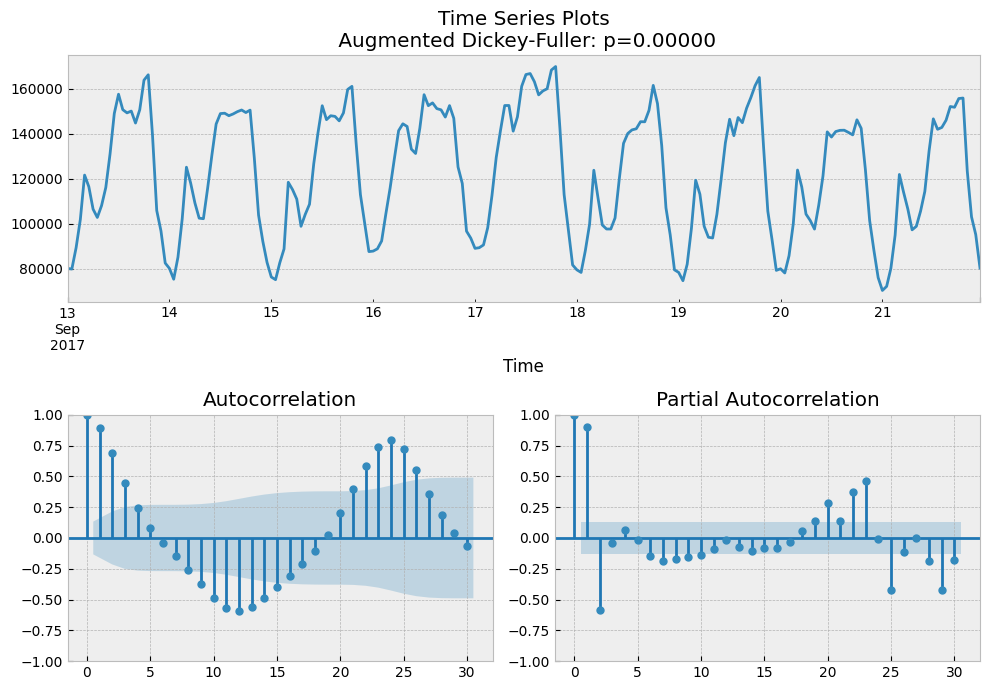

In [ ]:
tsplot(df.Ads, lags=30)

The Augmented Dickey-Fuller test shows a p-value of 0 < 0.05, this means we reject the null hypothesis and the time series is stationary as seen in the plot. The ACF shows a geometric decay in correlation while the PACF shows a sharp decrease, this indicates that the data can be modelled by an Autoregressive (AR) model.  

## Feature Engineering

In this section, following the 24h seasonality observed in the time series, I will create 24 lags of the target variable and some datetime attributes as features

In [ ]:
# Add lags of the target variable up to a cycle (24)
df.columns = ['y']
for i in range(1, 25):
    df[f"lag_{i}"] = df.y.shift(i)

# Add date and time features
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df['is_weekend'] = df.weekday.isin([5,6])*1
df.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,155665.0,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,155890.0,155665.0,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,123395.0,155890.0,155665.0,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,103080.0,123395.0,155890.0,155665.0,151790.0,152120.0,146020.0,142815.0,141995.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,95155.0,103080.0,123395.0,155890.0,155665.0,151790.0,152120.0,146020.0,142815.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


In [ ]:
# Split data into X and y
df = df.dropna()
X = df.drop(['y'], axis=1)
y = df.y

# Split data into train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=False, random_state=1)   

# Scale data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Important things to note here;


1.   If you are working with a time series data, set `shuffle=False` to retain the sequence of the data, this information is required for accurate prediction
2.   Some linear estimators like KNN, SVM and regression models require transforming the features to have equal range to prevent features with high range from dominating others which may be equally important. One way to achieve this is by standardization using the `StandardScaler()` function
3. The best way to use `StandardScaler()` is to `fit_transform(X_train)` and ONLY `transform(X_test)`. 
4. **CAUTION:** Do not `fit_transform(X_test)` to prevent data leakage, you want to treat your test set exclusively as an unseen data which is meant only for testing, this would give you a realistic (and not optimistic) model performance. 

I will elaborate on how to achieve this when using cross validation for hyperparameter tuning in the regularized regression section. I call this best practise.

## Modelling and Testing

### Unregularized Linear Regression

In this section, I will be using the unregularized linear regression model from sklearn without hyperparameter tuning

In [ ]:
# Fit model
lr = LinearRegression()
lr_fitted = lr.fit(X_train_s, y_train)

# Make predictions
predictions_train = lr_fitted.predict(X_train_s)
predictions_test = lr_fitted.predict(X_test_s)

In [ ]:
# Define function to evaluate model performance
def WAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

The function defined above for evaluating model performance is the weighted average percentage error (WAPE) or MAD/mean ratio, the error is weighted by dividing it by the average of the true values.

In [ ]:
# Evaluate model performance
train_error = WAPE(y_train, predictions_train)
test_error = WAPE(y_test, predictions_test)

print("Train set WAPE: {:.2f}%".format(train_error))
print("Test set WAPE: {:.2f}%".format(test_error))

Train set WAPE: 3.63%
Test set WAPE: 4.73%


In [ ]:
# Define function to plot true labels vs model predictions
def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    prediction = model.predict(X_test)
    plt.figure(figsize=(7, 5))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    error = WAPE(y_test, prediction)     
    if (test_data==True):
        plt.title("Test data WAPE {0:.2f}%".format(error))
    else:
        plt.title("Train data WAPE {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [ ]:
# Define function to plot model coefficients
def plotCoefficients(model, X_train):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(7, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

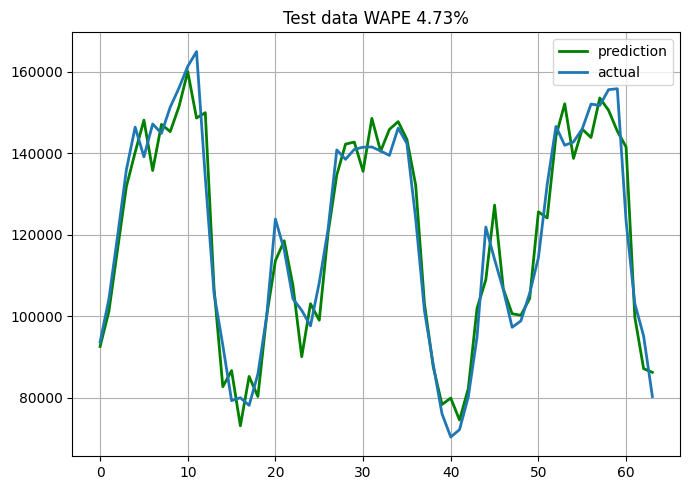

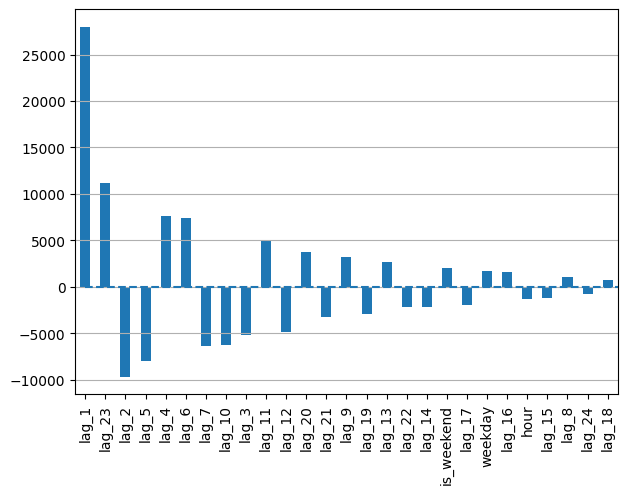

In [ ]:
plotModelResults(lr_fitted, X_train=X_train_s, X_test=X_test_s, y_test=y_test, plot_intervals=True, test_data=True)
plotCoefficients(lr_fitted, X_train)

### Regularized regression

The best way to develop an ML workflow for an estimator that requires data transformation before modelling is to use a pipeline during cross validation. Cross validation is used for hyperparameter tuning when you are working with a low to medium-sized dataset, by this, the model is trained and validated with different splits of the data to obtain the best hyperparameter, this method optimizes model performance. 

The pipeline will help you perform proper scaling during cross validation by not scaling the validation set (i.e treating it like the test set to obtain realistic model performance) like I mentioned earlier. 

I will highlight the important steps below;
 
1. Split your data into training and test set, be sure to set `shuffle=False` when working with a time series data
2. Define the transformation function
3. Define the estimator. In addition to transformation, regression models require regularization to control the growth of the model coefficients thereby preventing overfitting, this can be done using Lasso (L1), Ridge (L2) and other regularization methods.
4. Set up your pipeline to include transformation followed by modelling. If there are more steps in your workflow that needs to be done sequentially, this is where to add them
5. Set up your parameter grid, the benefit of this is that if you need to tune more than one hyperparameter, you can include them all here with the range of values to test. **CAUTION:** You do not need to use a for loop to tune hyperparameters, this is not the most efficient way.
6. Specify your cross validation splitting strategy. If you are working with time series, you can use the `TimeSeriesSplit()` function to preserve the sequential information in the data. On the otherhand if you are working with cross sectional data, you can skip this step and set `cv=integer` in the grid search object
7. Define the `GridSearchCV()` object to perform cross validation. Note the order of the parameters; the pipeline, parameter grid, cv and scoring method. If your parameter grid is very large, you may consider using `RandomizedSearchCV()` function.
8. Fit the grid search object on the training data from step 1 i.e (unscaled data), scaling will be properly done in the pipeline
9. You can see the best hyperparameters for your model by calling the `best_params_` attribute

The code to illustrate the above steps is presented below;

In [ ]:
# Improve the performance of the model with Ridge regularization
# Obtain the best hyperparameter in a grid search

# Load the data and split (unscaled)
X = df.drop(['y'], axis=1)
y = df.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=False, random_state=1)

# Set up the components of the pipeline
scaler = StandardScaler()
ridge = Ridge(max_iter=10000)      # Ridge (L2 regularized regression)

# Set up the pipeline with two steps: scale and fit
pipe = Pipeline([("scaler", scaler), ("ridge", ridge)])

# Set up the parameter grid for hyperparameter tuning during CV
param_grid = [{'ridge__alpha':[1000,500,100,50,10,5,1,.5,.1]}]

# For time-series cross-validation set 5 folds for grid search
tscv = TimeSeriesSplit(n_splits=5)

# Run grid search to find the best parameters
grid_search_object = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")   
grid_search_object.fit(X_train, y_train)     # Fit with unscaled data
best_parameters = grid_search_object.best_params_
print("best alpha: ", best_parameters['ridge__alpha'])

best alpha:  10


**Model Testing**

The step continues...
10. Instantiate a new estimator with the best hyperparameter obtained in steps 9
11. Scale your data appropriately as explained earlier 
12. Fit your best model with all of your training data (i.e scaled)
13. Use your best model to predict the test set that was held out in step 1.
14. Obtain your model performance

Train set WAPE: 4.12%
Test set WAPE: 4.34%


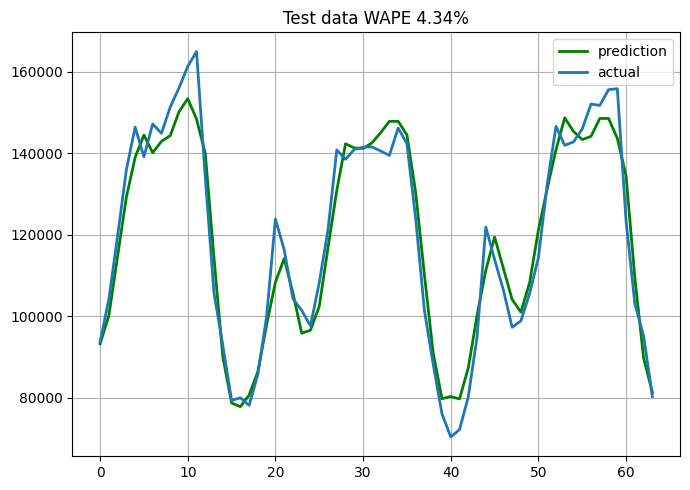

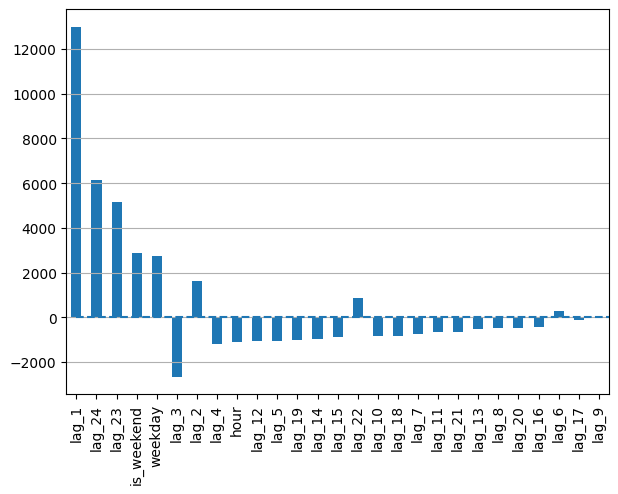

In [ ]:
# Instantiate and fit the best ridge (using the best parameters)
best_ridge = Ridge(alpha=best_parameters['ridge__alpha'])

# Do not forget to scale the data
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
best_ridge.fit(X_train_s, y_train)            # Scaled data

plotModelResults(best_ridge, X_train=X_train_s, X_test=X_test_s, y_test=y_test, plot_intervals=True, test_data=True)
plotCoefficients(best_ridge, X_train) 

predictions_train = best_ridge.predict(X_train_s)
predictions_test = best_ridge.predict(X_test_s)

# Evaluate model performance using MAD_mean ratio
train_error = WAPE(y_train, predictions_train)
test_error = WAPE(y_test, predictions_test)

print("Train set WAPE: {:.2f}%".format(train_error))
print("Test set WAPE: {:.2f}%".format(test_error))

From the results above, comparing this to the performance of the unregularized model, we see that the training error increased while the test error reduced (which is what we care about). Also the coefficients of the model were shrinked, all these are the effect of regularization, designed to prevent overfitting and improve the performance of the model on the test set

Most importantly, we can be confident that we are getting a realistic model performance since we employed the best practise in developing our ML workflow.

**Testing the best model direcly from the GridSearch Object**

It is interesting to note that when the gridsearch object obtains the best hyperparameter, it refits the best model with all of the training set so we can test the best model directly, this is done by simply calling `predict(X_test)` on the grid search object as shown below. Note that unscaled data is used as scaling will be done in the pipeline

In [ ]:
# Predict the test set directly from the grid search object
predictions_train = grid_search_object.predict(X_train)      # Use the unscaled data, scaling will be done in the pipeline
predictions_test = grid_search_object.predict(X_test)

# Evaluate model performance using MAD_mean ratio
train_error = WAPE(y_train, predictions_train)
test_error = WAPE(y_test, predictions_test)

print("Train set WAPE: {:.2f}%".format(train_error))
print("Test set WAPE: {:.2f}%".format(test_error))

Train set WAPE: 4.12%
Test set WAPE: 4.34%


Confirm that we obtained the same result as instantiating a new model, a simple short cut!

In this notebook I have presented the importance of regularization when using regression models and best practises for developing ML workflows for estimators that require data transformation before modelling. Hope this was helpful, thanks for reading.